# NoETL Weather Examples

This notebook covers how to use NoETL with the weather example playbooks:

1. Registering the weather playbooks
2. Executing the playbooks
3. Validating the results by querying the tables created in Postgres and DuckDB

## Prerequisites

Before running this notebook, make sure you have:

1. The NoETL server running
2. Postgres database running
3. The weather example playbooks available in the `examples/weather` directory


### This notebook shows how to:

- Register the weather example playbooks with the NoETL catalog
- Execute the playbooks with custom payloads
- Query the Postgres database using the NoETL API's /postgres/execute endpoint to validate the execution results
- Export the data to DuckDB for further analysis
- Visualize the temperature data from the playbook executions
- This workflow can be adapted for other NoETL playbooks to register, execute, and analyze their results. 
- Using the NoETL API for database queries provides a standardized way to access the database without direct database quiring in the notebook.


## 1. Setup and Imports

Import the necessary libraries and set up our environment.


In [18]:
import base64
import requests
import json
import os
import time
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# the NoETL API endpoint
NOETL_API_HOST = "server"  # servier is the service name from docker-compose
NOETL_API_PORT = 8080
NOETL_API_URL = f"http://{NOETL_API_HOST}:{NOETL_API_PORT}/api"

# the Postgres connection
POSTGRES_USER = "demo"
POSTGRES_PASSWORD = "demo"
POSTGRES_SCHEMA = "public"
POSTGRES_DB = "demo_noetl"
POSTGRES_HOST = "database"
POSTGRES_PORT = 5432
# API Configuration
NOETL_USER = "noetl"
NOETL_PASSWORD = "noetl"
NOETL_SCHEMA ="noetl"

# the DuckDB connection
DUCKDB_PATH = "/home/jovyan/data/weather.duckdb"

print(f"NoETL API URL: {NOETL_API_URL}")
print(f"Postgres connection: {POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}")
print(f"DuckDB path: {DUCKDB_PATH}")


NoETL API URL: http://server:8080/api
Postgres connection: database:5432/demo_noetl
DuckDB path: /home/jovyan/data/weather.duckdb


## 2. Register the Weather Playbooks

Before executing the playbooks, register them with the NoETL catalog.


In [20]:
def register_playbook(playbook_path):
    """Register a playbook with the NoETL catalog"""
    with open(playbook_path, 'rb') as f:
        playbook_content = f.read()
    
    playbook_base64 = base64.b64encode(playbook_content).decode('utf-8')
    
    response = requests.post(
        f"{NOETL_API_URL}/catalog/register",
        headers={"Content-Type": "application/json"},
        json={"content_base64": playbook_base64}
    )
    
    print(f"Status code: {response.status_code}")
    if response.status_code == 200:
        result = response.json()
        print(f"Registered playbook: {result.get('resource_path')} (version {result.get('resource_version')})")
        return result
    else:
        print(f"Error: {response.text}")
        return None


In [21]:
# Register the simple weather example playbook
weather_example_result = register_playbook("/home/jovyan/examples/weather/weather_example.yaml")
print(weather_example_result)

# Register the weather loop example playbook
weather_loop_example_result = register_playbook("/home/jovyan/examples/weather/weather_loop_example.yaml")
print(weather_loop_example_result)


Status code: 200
Registered playbook: examples/weather_example (version 0.1.4)
{'status': 'success', 'message': "Resource 'examples/weather_example' version '0.1.4' registered.", 'resource_path': 'examples/weather_example', 'resource_version': '0.1.4', 'resource_type': 'playbooks'}
Status code: 200
Registered playbook: examples/weather_loop_example (version 0.1.4)
{'status': 'success', 'message': "Resource 'examples/weather_loop_example' version '0.1.4' registered.", 'resource_path': 'examples/weather_loop_example', 'resource_version': '0.1.4', 'resource_type': 'playbooks'}


## 3. Execute the Weather Example Playbook

Execute the simple weather example playbook.


In [4]:
def execute_playbook(path, payload=None, sync_to_postgres=True):
    """Execute a playbook synchronously"""
    request_data = {
        "path": path,
        "sync_to_postgres": sync_to_postgres
    }
    
    if payload:
        request_data["input_payload"] = payload
    
    response = requests.post(
        f"{NOETL_API_URL}/agent/execute",
        headers={"Content-Type": "application/json"},
        json=request_data
    )
    
    print(f"Status code: {response.status_code}")
    if response.status_code == 200:
        result = response.json()
        print(f"Execution ID: {result.get('execution_id')}")
        print(f"Status: {result.get('status')}")
        return result
    else:
        print(f"Error: {response.text}")
        return None


In [22]:
# Execute the simple weather example playbook
weather_example_payload = {
    "cities": [
        {
            "name": "New York",
            "lat": 40.71,
            "lon": -74.01
        }
    ],
    "temperature_threshold": 20
}

weather_example_execution = execute_playbook(
    "examples/weather_example",
    payload=weather_example_payload,
    sync_to_postgres=True
)
print(weather_example_payload)

Status code: 200
Execution ID: d1003832-c936-497c-8d1d-b7d84a9ae649
Status: success
{'cities': [{'name': 'New York', 'lat': 40.71, 'lon': -74.01}], 'temperature_threshold': 20}


## 4. Execute the Weather Loop Example Playbook

Execute the more complex weather loop example playbook.


In [25]:
# Execute the weather loop example playbook
weather_loop_example_payload = {
    "cities": [
        {
            "name": "New York",
            "lat": 40.71,
            "lon": -74.01
        },
        {
            "name": "London",
            "lat": 51.51,
            "lon": -0.13
        },
        {
            "name": "Tokyo",
            "lat": 35.68,
            "lon": 139.77
        }
    ],
    "temperature_threshold": 25
}

weather_loop_example_execution = execute_playbook(
    "examples/weather_loop_example",
    payload=weather_loop_example_payload,
    sync_to_postgres=True
)
print(json.dumps(weather_loop_example_execution, indent=4))

Status code: 200
Execution ID: ebd29e08-f1ae-4ac1-ada1-e6de77906aab
Status: success
{
    "status": "success",
    "message": "Agent executed for playbooks 'examples/weather_loop_example' version '0.1.4'.",
    "result": {
        "end_city_loop": {
            "alerts": "[{'city': 'New York', 'max_temp': 29.3, 'alert': True}, {'city': 'London', 'max_temp': 24.9, 'alert': False}, {'city': 'Tokyo', 'max_temp': 35.6, 'alert': True}]"
        },
        "start": {
            "message": "Routing step start completed"
        },
        "fetch_and_evaluate": {
            "city": "New York",
            "max_temp": 29.3,
            "alert": true
        },
        "aggregate_alerts": {
            "global_alert": true,
            "summary": {
                "alert_cities": [
                    "New York",
                    "Tokyo"
                ],
                "count": 2
            }
        },
        "log_aggregate_result": {
            "logged": true,
            "summary":

## 5. Validate Results in Postgres

Run query the Postgres database to validate the results of the playbook executions. We'll use the NoETL API's `/postgres/execute` endpoint to run our queries instead of connecting directly to the database.


In [27]:
def query_postgres(query, parameters=None):
    """
    Execute a query against the Postgres database using the NoETL API endpoint.
    
    This function sends the query to the NoETL API's /postgres/execute endpoint
    instead of connecting directly to the database. The API handles the database
    connection and returns the results in a standardized format.
    
    The query is encoded as base64 to avoid issues with special characters like
    newlines in JSON.
    
    Args:
        query (str): SQL query to execute
        parameters (list, optional): Parameters for the query
        
    Returns:
        pd.DataFrame: Results of the query as a DataFrame
    """
    # parameters should be is always a list, even if None
    if parameters is None:
        parameters = []
    elif not isinstance(parameters, list):
        parameters = [parameters]
    
    # the query encoded as base64 to avoid issues with newlines and special characters
    query_base64 = base64.b64encode(query.encode('utf-8')).decode('utf-8')
    
    # the payload with base64-encoded query and parameters
    payload = {
        "query_base64": query_base64,
        "parameters": parameters
    }
    
    response = requests.post(
        f"{NOETL_API_URL}/postgres/execute",
        headers={"Content-Type": "application/json"},
        json=payload
    )
    
    if response.status_code == 200:
        result = response.json()
        # converting the results to a DataFrame
        if result["results"]:
            return pd.DataFrame(result["results"])
        else:
            # returns empty DataFrame with columns if available
            return pd.DataFrame(columns=result.get("columns", []))
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return pd.DataFrame()


In [8]:
# Query the executions table to see our playbook executions
executions_query = f"""
WITH latest_events AS (
    SELECT 
        execution_id,
        MAX(timestamp) as latest_timestamp
    FROM {NOETL_SCHEMA}.event_log
    GROUP BY execution_id
),
execution_metadata AS (
    SELECT 
        e.execution_id,
        e.event_type,
        e.status,
        e.timestamp as created_at,
        e.timestamp as updated_at,
        e.metadata,
        e.input_context
    FROM {NOETL_SCHEMA}.event_log e
    JOIN latest_events le ON e.execution_id = le.execution_id AND e.timestamp = le.latest_timestamp
)
SELECT 
    em.execution_id,
    COALESCE(
        JSON_EXTRACT_PATH_TEXT(em.metadata::json, 'resource_path'),
        JSON_EXTRACT_PATH_TEXT(em.input_context::json, 'path')
    ) as playbook_path,
    em.status,
    em.created_at,
    em.updated_at
FROM execution_metadata em
WHERE 
    COALESCE(
        JSON_EXTRACT_PATH_TEXT(em.metadata::json, 'resource_path'),
        JSON_EXTRACT_PATH_TEXT(em.input_context::json, 'path')
    ) IN ('examples/weather_example', 'examples/weather_loop_example')
ORDER BY em.created_at DESC
LIMIT 10
"""

executions_df = query_postgres(executions_query)
display(executions_df)


,execution_id,playbook_path,status,created_at,updated_at


In [28]:
# Query the execution steps to see the steps that were executed
if weather_example_execution and 'execution_id' in weather_example_execution:
    execution_id = weather_example_execution['execution_id']
    
    steps_query = f"""
    SELECT 
        node_id as step_id, 
        node_name as step_name, 
        status, 
        timestamp as created_at, 
        timestamp as updated_at
    FROM {NOETL_SCHEMA}.event_log
    WHERE 
        execution_id = '{execution_id}'
        AND node_id IS NOT NULL
        AND node_name IS NOT NULL
    ORDER BY timestamp
    """
    
    steps_df = query_postgres(steps_query)
    print(f"Steps for execution {execution_id}:")
    display(steps_df)


Steps for execution d1003832-c936-497c-8d1d-b7d84a9ae649:


,step_id,step_name,status,created_at,updated_at
0,d1003832-c936-497c-8d1d-b7d84a9ae649_context_j...,jobId,success,2025-08-02T23:10:11.203130,2025-08-02T23:10:11.203130
1,d1003832-c936-497c-8d1d-b7d84a9ae649_context_s...,state,success,2025-08-02T23:10:11.203666,2025-08-02T23:10:11.203666
2,d1003832-c936-497c-8d1d-b7d84a9ae649_context_c...,cities,success,2025-08-02T23:10:11.203999,2025-08-02T23:10:11.203999
3,d1003832-c936-497c-8d1d-b7d84a9ae649_context_t...,temperature_threshold,success,2025-08-02T23:10:11.204320,2025-08-02T23:10:11.204320
4,d1003832-c936-497c-8d1d-b7d84a9ae649_context_b...,base_url,success,2025-08-02T23:10:11.204667,2025-08-02T23:10:11.204667
5,d1003832-c936-497c-8d1d-b7d84a9ae649_context_w...,workload,success,2025-08-02T23:10:11.204997,2025-08-02T23:10:11.204997
6,d1003832-c936-497c-8d1d-b7d84a9ae649_context_e...,execution_start,success,2025-08-02T23:10:11.244752,2025-08-02T23:10:11.244752
7,d1003832-c936-497c-8d1d-b7d84a9ae649,weather,in_progress,2025-08-02T23:10:11.245595,2025-08-02T23:10:11.245595
8,ec77dfd7-be01-433e-b46a-432aa63849a2,start,in_progress,2025-08-02T23:10:11.247283,2025-08-02T23:10:11.247283
9,ec77dfd7-be01-433e-b46a-432aa63849a2,start,success,2025-08-02T23:10:11.248032,2025-08-02T23:10:11.248032


In [29]:
# the execution results to see the output of each step
if weather_example_execution and 'execution_id' in weather_example_execution:
    execution_id = weather_example_execution['execution_id']
    
    results_query = f"""
    SELECT 
        node_id as step_id, 
        node_name as step_name, 
        output_result as result_data,
        timestamp as created_at
    FROM {NOETL_SCHEMA}.event_log
    WHERE 
        execution_id = '{execution_id}'
        AND node_id IS NOT NULL
        AND node_name IS NOT NULL
        AND output_result IS NOT NULL
    ORDER BY timestamp
    """
    
    results_df = query_postgres(results_query)
    print(f"Results for execution {execution_id}:")
    
    # Format the JSON data for better display
    for i, row in results_df.iterrows():
        if row['result_data']:
            try:
                result_data = json.loads(row['result_data'])
                print(f"\nStep: {row['step_name']} (ID: {row['step_id']})")
                print(json.dumps(result_data, indent=2))
            except:
                print(f"\nStep: {row['step_name']} (ID: {row['step_id']})")
                print(row['result_data'])


Results for execution d1003832-c936-497c-8d1d-b7d84a9ae649:

Step: start (ID: ec77dfd7-be01-433e-b46a-432aa63849a2)
{
  "message": "Routing step start completed"
}

Step: start (ID: ec77dfd7-be01-433e-b46a-432aa63849a2)
{
  "message": "Routing step start completed"
}

Step: python_task (ID: 6b500b89-5502-4e03-905d-2509ac45ab6d)
{
  "city": "{'name': 'New York', 'lat': 40.71, 'lon': -74.01}",
  "max_temp": 29.3,
  "alert": true,
  "threshold": 20.0
}

Step: fetch_weather (ID: 8482fc33-a87f-43ca-92dd-82f806c1557d)
{
  "city": "{'name': 'New York', 'lat': 40.71, 'lon': -74.01}",
  "max_temp": 29.3,
  "alert": true,
  "threshold": 20.0
}

Step: fetch_weather (ID: bbb43ddc-43c7-4e9b-a955-9aadd839edc5)
{
  "city": "{'name': 'New York', 'lat': 40.71, 'lon': -74.01}",
  "max_temp": 29.3,
  "alert": true,
  "threshold": 20.0
}

Step: fetch_weather (ID: bbb43ddc-43c7-4e9b-a955-9aadd839edc5)
{
  "city": "{'name': 'New York', 'lat': 40.71, 'lon': -74.01}",
  "max_temp": 29.3,
  "alert": true,
  "t

## 6. Analyze Weather Loop Example Results

Now let's analyze the results of the weather loop example, which processes multiple cities.


In [30]:
# query the execution steps for the weather loop example
if weather_loop_example_execution and 'execution_id' in weather_loop_example_execution:
    execution_id = weather_loop_example_execution['execution_id']
    
    steps_query = f"""
    SELECT 
        node_id as step_id, 
        node_name as step_name, 
        status, 
        timestamp as created_at, 
        timestamp as updated_at
    FROM {NOETL_SCHEMA}.event_log
    WHERE 
        execution_id = '{execution_id}'
        AND node_id IS NOT NULL
        AND node_name IS NOT NULL
    ORDER BY timestamp
    """
    
    steps_df = query_postgres(steps_query)
    print(f"Steps for weather loop execution {execution_id}:")
    display(steps_df)


Steps for weather loop execution ebd29e08-f1ae-4ac1-ada1-e6de77906aab:


,step_id,step_name,status,created_at,updated_at
0,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_j...,jobId,success,2025-08-02T23:12:50.409445,2025-08-02T23:12:50.409445
1,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_s...,state,success,2025-08-02T23:12:50.409838,2025-08-02T23:12:50.409838
2,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_c...,cities,success,2025-08-02T23:12:50.410109,2025-08-02T23:12:50.410109
3,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_b...,base_url,success,2025-08-02T23:12:50.410385,2025-08-02T23:12:50.410385
4,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_t...,temperature_threshold,success,2025-08-02T23:12:50.410627,2025-08-02T23:12:50.410627
...,...,...,...,...,...
122,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_s...,store_aggregate_result.data,success,2025-08-02T23:12:52.476564,2025-08-02T23:12:52.476564
123,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_context_r...,result,success,2025-08-02T23:12:52.476900,2025-08-02T23:12:52.476900
124,fed41b49-e78d-4b82-9ec4-012caa44c3da,store_aggregate_result,success,2025-08-02T23:12:52.477199,2025-08-02T23:12:52.477199
125,ebd29e08-f1ae-4ac1-ada1-e6de77906aab_transitio...,transition_to_end,success,2025-08-02T23:12:52.477531,2025-08-02T23:12:52.477531


,City,Max Temperature (°C)
0,New York,29.3
1,New York,29.3
2,London,24.9
3,London,24.9
4,Tokyo,35.6
5,Tokyo,35.6


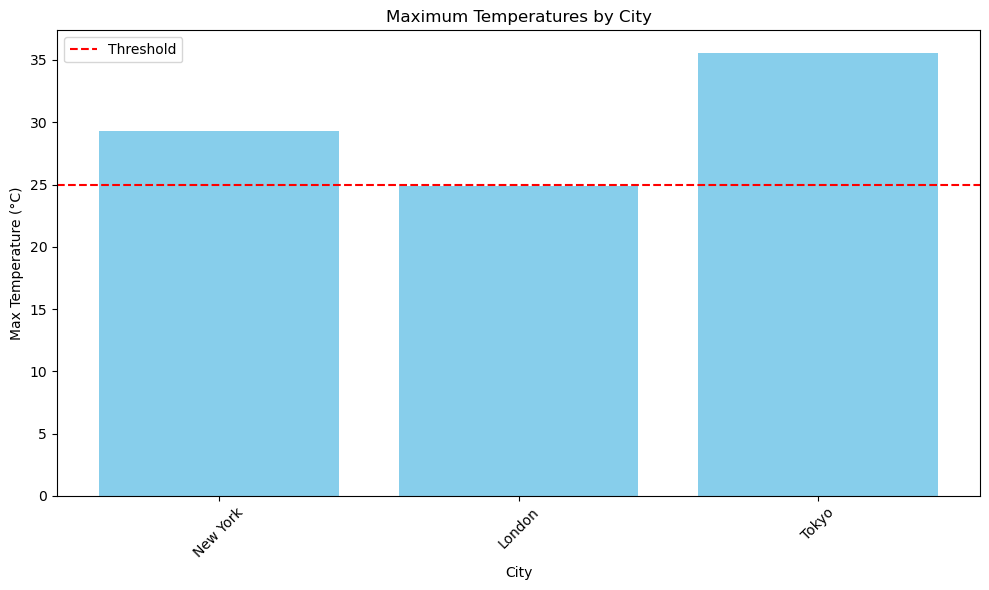

In [35]:
# extract temperature data from the execution results
if weather_loop_example_execution and 'execution_id' in weather_loop_example_execution:
    execution_id = weather_loop_example_execution['execution_id']
    
    # fetch_and_evaluate steps which contain the temperature data
    temp_query = f"""
    SELECT 
        node_id as step_id, 
        node_name as step_name, 
        output_result as result_data,
        timestamp as created_at
    FROM {NOETL_SCHEMA}.event_log
    WHERE 
        execution_id = '{execution_id}'
        AND node_name = 'fetch_and_evaluate'
        AND output_result IS NOT NULL
    ORDER BY timestamp
    """
    
    temp_df = query_postgres(temp_query)
    
    # extract city names and temperatures
    cities = []
    temperatures = []
    
    for i, row in temp_df.iterrows():
        if row['result_data']:
            try:
                result_data = json.loads(row['result_data'])
                city = result_data.get('city', 'Unknown')
                max_temp = result_data.get('max_temp', 0)
                cities.append(city)
                temperatures.append(max_temp)
            except:
                pass
    
    weather_data = pd.DataFrame({
        'City': cities,
        'Max Temperature (°C)': temperatures
    })
    
    display(weather_data)
    
    # a bar chart of temperatures by city
    plt.figure(figsize=(10, 6))
    plt.bar(weather_data['City'], weather_data['Max Temperature (°C)'], color='skyblue')
    plt.axhline(y=weather_loop_example_payload['temperature_threshold'], color='red', linestyle='--', label='Threshold')
    plt.xlabel('City')
    plt.ylabel('Max Temperature (°C)')
    plt.title('Maximum Temperatures by City')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 7. Export Data to DuckDB

Export the execution data to DuckDB for further analysis.


In [37]:
con = duckdb.connect(DUCKDB_PATH)

# export the execution data to DuckDB
executions_query = f"""
WITH latest_events AS (
    SELECT 
        execution_id,
        MAX(timestamp) as latest_timestamp
    FROM {NOETL_SCHEMA}.event_log
    GROUP BY execution_id
),
execution_metadata AS (
    SELECT 
        e.execution_id,
        e.event_type,
        e.status,
        e.timestamp as created_at,
        e.timestamp as updated_at,
        e.metadata,
        e.input_context
    FROM {NOETL_SCHEMA}.event_log e
    JOIN latest_events le ON e.execution_id = le.execution_id AND e.timestamp = le.latest_timestamp
)
SELECT 
    em.execution_id,
    COALESCE(
        JSON_EXTRACT_PATH_TEXT(em.metadata::json, 'resource_path'),
        JSON_EXTRACT_PATH_TEXT(em.input_context::json, 'path')
    ) as playbook_path,
    em.status,
    em.created_at,
    em.updated_at
FROM execution_metadata em
WHERE 
    COALESCE(
        JSON_EXTRACT_PATH_TEXT(em.metadata::json, 'resource_path'),
        JSON_EXTRACT_PATH_TEXT(em.input_context::json, 'path')
    ) IN ('examples/weather_example', 'examples/weather_loop_example')
"""

executions_df = query_postgres(executions_query)

con.execute("CREATE TABLE IF NOT EXISTS weather_executions AS SELECT * FROM executions_df")
print("Exported executions data to DuckDB")

steps_query = f"""
WITH execution_paths AS (
    SELECT 
        execution_id,
        COALESCE(
            JSON_EXTRACT_PATH_TEXT(metadata::json, 'resource_path'),
            JSON_EXTRACT_PATH_TEXT(input_context::json, 'path')
        ) as playbook_path
    FROM {NOETL_SCHEMA}.event_log
    WHERE metadata IS NOT NULL OR input_context IS NOT NULL
    GROUP BY execution_id, playbook_path
)
SELECT 
    el.node_id as step_id,
    el.node_name as step_name,
    el.status,
    el.timestamp as created_at,
    el.timestamp as updated_at,
    el.execution_id
FROM {NOETL_SCHEMA}.event_log el
JOIN execution_paths ep ON el.execution_id = ep.execution_id
WHERE 
    ep.playbook_path IN ('examples/weather_example', 'examples/weather_loop_example')
    AND el.node_id IS NOT NULL
    AND el.node_name IS NOT NULL
"""

steps_df = query_postgres(steps_query)
con.execute("CREATE TABLE IF NOT EXISTS weather_execution_steps AS SELECT * FROM steps_df")
print("Exported execution steps data to DuckDB")

# Export the execution results data
results_query = f"""
WITH execution_paths AS (
    SELECT 
        execution_id,
        COALESCE(
            JSON_EXTRACT_PATH_TEXT(metadata::json, 'resource_path'),
            JSON_EXTRACT_PATH_TEXT(input_context::json, 'path')
        ) as playbook_path
    FROM {NOETL_SCHEMA}.event_log
    WHERE metadata IS NOT NULL OR input_context IS NOT NULL
    GROUP BY execution_id, playbook_path
)
SELECT 
    el.node_id as step_id,
    el.node_name as step_name,
    el.output_result as result_data,
    el.timestamp as created_at,
    el.execution_id
FROM {NOETL_SCHEMA}.event_log el
JOIN execution_paths ep ON el.execution_id = ep.execution_id
WHERE 
    ep.playbook_path IN ('examples/weather_example', 'examples/weather_loop_example')
    AND el.node_id IS NOT NULL
    AND el.node_name IS NOT NULL
    AND el.output_result IS NOT NULL
"""

results_df = query_postgres(results_query)
con.execute("CREATE TABLE IF NOT EXISTS weather_execution_results AS SELECT * FROM results_df")
print("Exported execution results data to DuckDB")


Exported executions data to DuckDB
Exported execution steps data to DuckDB
Exported execution results data to DuckDB


## 8. Query DuckDB for Analysis

Query the DuckDB database to analyze the execution data.


In [38]:
# get execution statistics
execution_stats = con.execute("""
SELECT 
    playbook_path,
    COUNT(*) as execution_count,
    MIN(created_at) as first_execution,
    MAX(created_at) as last_execution
FROM weather_executions
GROUP BY playbook_path
""").fetchdf()

display(execution_stats)


,playbook_path,execution_count,first_execution,last_execution


In [15]:
# Query DuckDB to get step statistics
step_stats = con.execute("""
SELECT 
    e.playbook_path,
    s.step_name,
    COUNT(*) as step_count,
    COUNT(CASE WHEN s.status = 'completed' THEN 1 END) as completed_count,
    COUNT(CASE WHEN s.status = 'failed' THEN 1 END) as failed_count
FROM weather_execution_steps s
JOIN weather_executions e ON s.execution_id = e.execution_id
GROUP BY e.playbook_path, s.step_name
ORDER BY e.playbook_path, s.step_name
""").fetchdf()

display(step_stats)


,playbook_path,step_name,step_count,completed_count,failed_count


In [16]:
# Extract temperature data from DuckDB
temperature_data = con.execute("""
WITH parsed_data AS (
  SELECT 
    r.execution_id,
    r.step_id,
    r.step_name,
    TRY_CAST(r.result_data AS JSON) as result_json
  FROM weather_execution_results r
  WHERE r.step_name = 'fetch_and_evaluate'
    AND r.result_data IS NOT NULL
)
SELECT 
  p.execution_id,
  p.step_id,
  JSON_EXTRACT_STRING(p.result_json, '$.city') as city,
  CAST(JSON_EXTRACT_STRING(p.result_json, '$.max_temp') AS DOUBLE) as max_temp,
  CAST(JSON_EXTRACT_STRING(p.result_json, '$.threshold') AS DOUBLE) as threshold,
  CAST(JSON_EXTRACT_STRING(p.result_json, '$.alert') AS BOOLEAN) as alert
FROM parsed_data p
WHERE JSON_EXTRACT_STRING(p.result_json, '$.city') IS NOT NULL
""").fetchdf()

display(temperature_data)


,execution_id,step_id,city,max_temp,threshold,alert


In [39]:
# Create a visualization of temperature data
if not temperature_data.empty:
    plt.figure(figsize=(12, 6))
    
    # Group by city and get the average max temperature
    city_temps = temperature_data.groupby('city')['max_temp'].mean().reset_index()
    
    # Sort by temperature
    city_temps = city_temps.sort_values('max_temp', ascending=False)
    
    # Create the bar chart
    plt.bar(city_temps['city'], city_temps['max_temp'], color='skyblue')
    
    # Add a horizontal line for the average threshold
    avg_threshold = temperature_data['threshold'].mean()
    plt.axhline(y=avg_threshold, color='red', linestyle='--', label=f'Avg Threshold ({avg_threshold:.1f}°C)')
    
    plt.xlabel('City')
    plt.ylabel('Average Max Temperature (°C)')
    plt.title('Average Maximum Temperatures by City')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create a pie chart of alerts vs. no alerts
    alert_counts = temperature_data['alert'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(alert_counts, labels=['No Alert', 'Alert'] if False in alert_counts.index else ['Alert', 'No Alert'],
            autopct='%1.1f%%', colors=['lightgreen', 'salmon'] if False in alert_counts.index else ['salmon', 'lightgreen'])
    plt.title('Temperature Alerts Distribution')
    plt.show()
